In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
from helper import Helper
from thresholder import Thresholder
from calibrator import Calibrator
from curvature import Curvature
from transformer import Transformer
from lane_finder import LaneFinder


from pipeline import PipeLine

### 1. Load a Sample Image

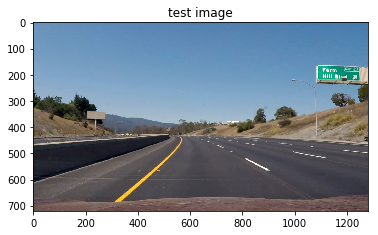

In [2]:
h = Helper()

root_dir = '../'
fname = 'project_video.mp4'
clip = VideoFileClip(root_dir + fname)
img = clip.get_frame(2)

h.plot_image(img, 'test image')

### 2. Calibrate Camera and Undistort image

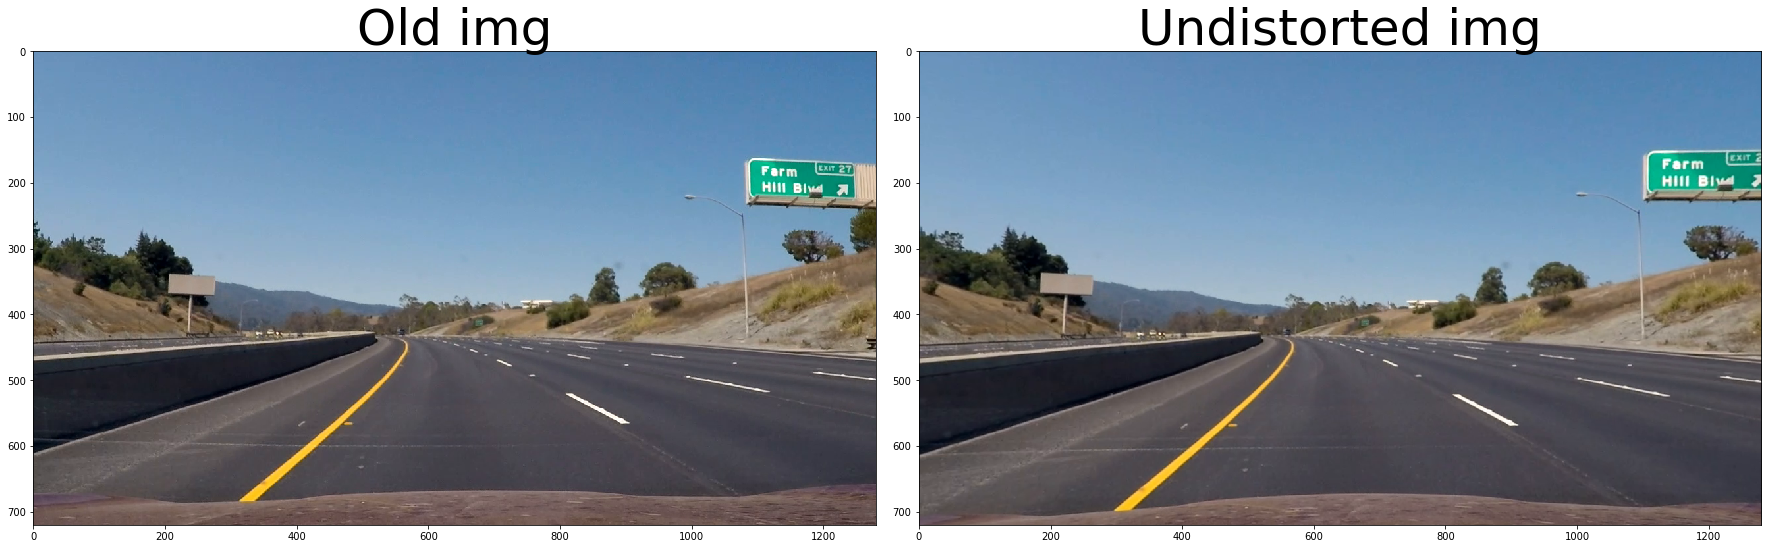

In [3]:

cal = Calibrator(x_corners=9, y_corners=6)

calib_images_path = '../camera_cal/*.jpg'
cal.compute_img_pts(calib_images_path, False)

test_image_path = '../camera_cal/calibration1.jpg'
cal.calibrate_camera(test_image_path)

cal.store_calib_coeffs('../data/calib_coeffs.pickle')


und_img = cal.undistort_image(img)
h.parallel_plots(img, 'Old img', und_img, 'Undistorted img')

### 3. Binarize the image by combining HLS + Absolute + Magnitude + Direction Thresholding techniques 

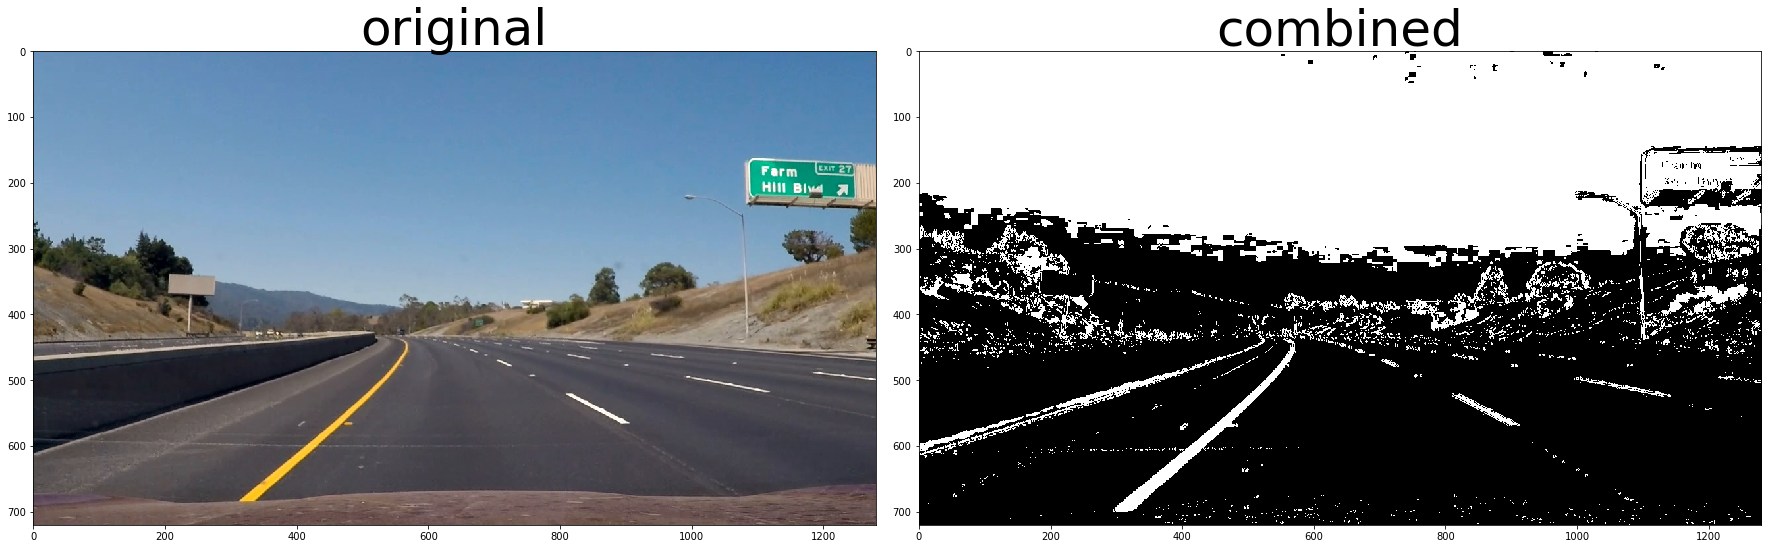

In [4]:
th = Thresholder()

ksize=3
s_thres = th.hls_threshold(und_img, thresh=(90, 255))
gradx = th.absolute_threshold(und_img, orient='x', thresh_min=20, thresh_max=100, sobel_kernel=ksize)
mag_binary = th.magnitude_threshold(und_img, sobel_kernel=ksize, mag_thresh=(20, 100))
dir_binary = th.direction_threshold(und_img, sobel_kernel=ksize, thresh=(0.7, 1.3))

bin_img = np.zeros_like(dir_binary)
bin_img[((gradx == 1)) | ((mag_binary == 1) & (dir_binary == 1)) | (s_thres == 1)] = 1

h.parallel_plots(img,'original', bin_img, 'combined', None, 'gray')

### 4. Perspective Transform the Image to get bird's eye view

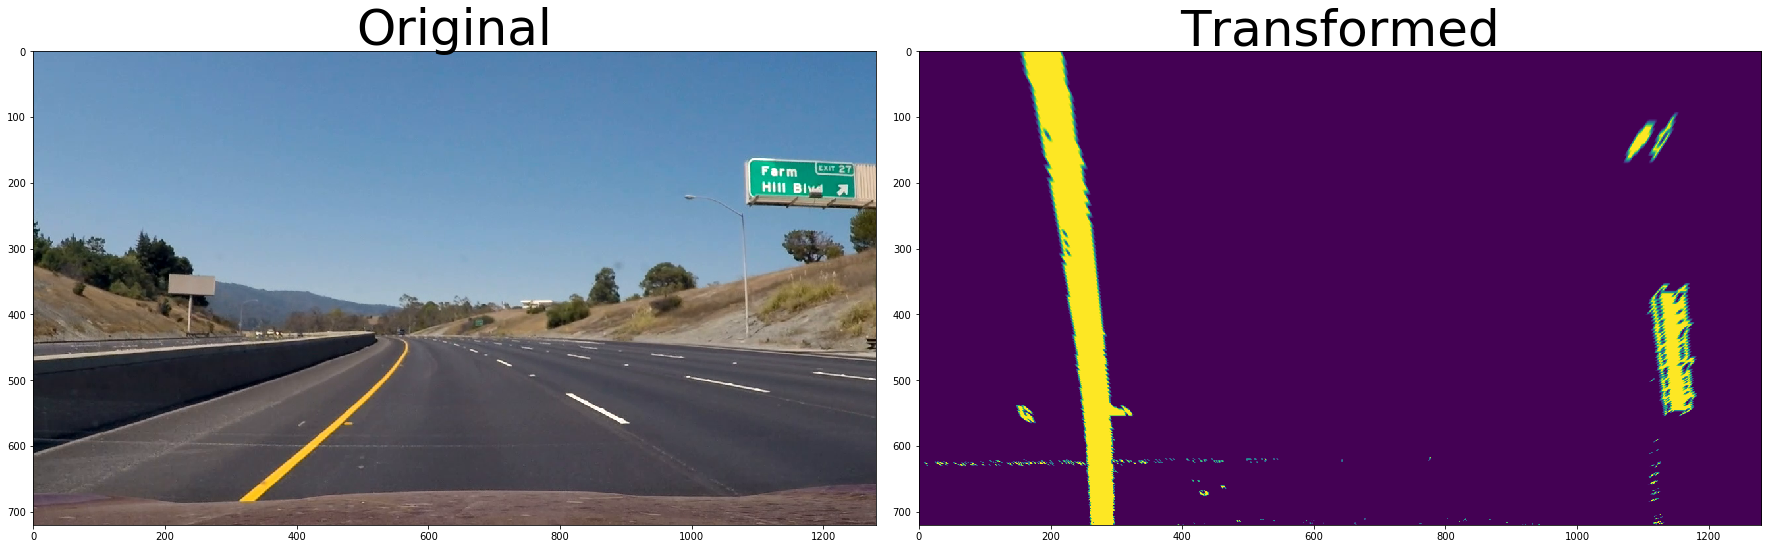

In [5]:
tr = Transformer()
corners = [(525, 499), (760, 499), (1047, 684), (253, 684)]
bin_warped = tr.transform(bin_img,corners , offset=200)

h.parallel_plots(img, 'Original', bin_warped, 'Transformed')

### 5. Plot Histogram of Pixel Intensities 

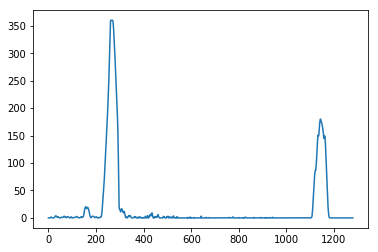

In [6]:
l = LaneFinder()
histogram = l.hist(bin_warped)
plt.plot(histogram)

### 6. Fit a 2nd degree polynomial

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


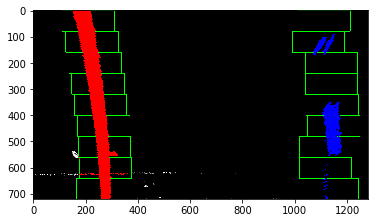

In [7]:
poly_img, fits = l.fit_polynomial(bin_warped)
plt.imshow(poly_img)

### 5. Fill the lane polygon, and overlay the lane onto the unwarped image

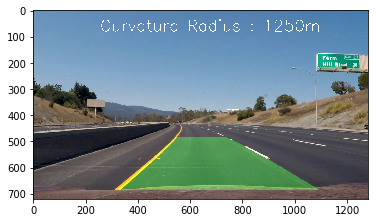

In [8]:
cur_obj = Curvature(30/720, 3.7/700)
plt.imshow(l.overlay_lane(img, l.left_fit, l.right_fit, tr, cur_obj))

### 6. Test pipeline on a single frame

<Figure size 432x288 with 0 Axes>

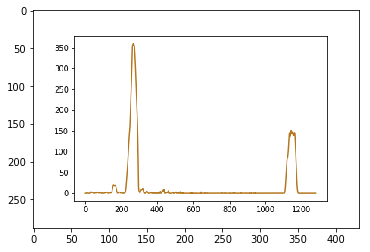

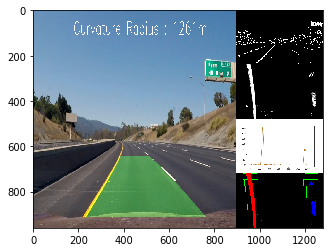

In [9]:
p = PipeLine(debug=False)
plt.imshow(p.extract_lanes(img))

### 7. Test pipeline on the project video.

In [ ]:
import os
import sys
f = open(os.devnull, 'w')
sys.stdout = f

p = PipeLine(debug=False)
root_dir = '../'
fname = 'project_video.mp4'
clip = VideoFileClip(root_dir + fname)
clip = clip.subclip(0,1)
video_clip = clip.fl_image(p.extract_lanes)
video_clip.write_videofile('../output/out_' + fname, audio=False)  
print ('please check :: ' + '../output/out_' + fname)